<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter7_8_9_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 - Ensemble Learing

Topics:

* Make predictions based on majority voting
* Using bagging to reduce overfitting by drawing random combinations of the training dataset with repetition
* Applying boosting to build powerful models from weak learners that learn from their mistakes

In [ ]:
from scipy.special import comb
import math

# implement the probability mass function
def ensemble_error(n_classifiers, error):
  k_start = int(math.ceil(n_classifiers / 2.0))
  probs = [comb(n_classifiers, k) * error**k *
           (1 - error) ** (n_classifiers - k)
           for k in range(k_start, n_classifiers + 1)]
  return sum(probs)

ensemble_error(n_classifiers=11, error=0.25)

np.float64(0.03432750701904297)

In [ ]:
int(math.ceil(11 / 2.))

6

In [ ]:
comb(11, 6)

np.float64(462.0)

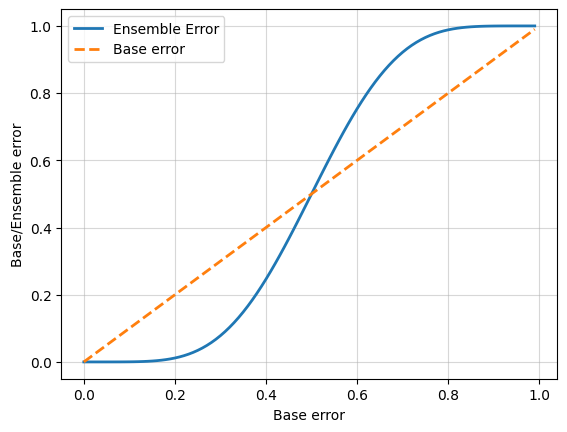

In [ ]:
# visualize relationship between ensemble and base errors
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifiers=11,
                             error=error)
              for error in error_range]

plt.plot(error_range,
         ens_errors,
         label='Ensemble Error',
         linewidth=2)

plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

## Combining classifiers via majority vote

### Implementing a simple majority vote classifer

In [ ]:
# `bincount` function counts number of occurrences of each class labels
import numpy as np

np.argmax(np.bincount([0,0,0, 1,1, 2],
                      weights=[0.1, 0.1, 0.1, 0.2, 0.2, 0.3]))

np.int64(1)

Certain classifiers in scikit-learn can also return probability of predicted class label via the `predict_proba` method.

$$ 𝐶1(𝒙) → [0.9, 0.1] $$

$$ 𝐶2(𝒙) → [0.8, 0.2] $$

$$ 𝐶3(𝒙) → [0.4, 0.6] $$

Using same weights (0.2, 0.2, 0.6):

$$ 𝑝(𝑖_0|𝒙) = 0.2 × 0.9 + 0.2 × 0.8 + 0.6 × 0.4 = 0.58 $$

$$ 𝑝(𝑖_1|𝒙) = 0.2 × 0.1 + 0.2 × 0.2 + 0.6 × 0.6 = 0.42 $$

y_pred = argmax_i[p(i0|x), p(i1|x)] = 0

In [ ]:
# implement weighted majority vote based on class probs
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [ ]:
p.argmax()

np.int64(0)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
import sklearn

base_classifiers = (ClassifierMixin, BaseEstimator)

class MajorityVoteClassifier(*base_classifiers):
  def __init__(self,
               classifiers,
               vote='classlabel',
               weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {key: value for key, value in
                              _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    if self.vote not in ('probability', 'classlabel'):
      raise ValueError(f'Vote must be "probability" or "classlabel";'
                  f' got (vote={self.vote})')

    if self.weights and len(self.weights) != len(self.classifiers):
      raise ValueError(f'Number of classifiers and weights must be '
              f'equal; got({len(self.weights)} weights, )'
              f'{len(self.classifiers)} classifiers')

    # Use LabelEncoder to ensure class labels starts with 0,
    # which is important for np.argmax() call in self.predict
    self.label_enc_ = LabelEncoder()
    self.label_enc_.fit(y)
    self.classes_ = self.label_enc_.classes_
    self.classifiers_ = []

    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X,
                                  self.label_enc_.transform(y))
      self.classifiers_.append(fitted_clf)

    return self

  def predict(self, X):
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X),
                           axis=1)

    else: # 'classlabel' vote

      # collect results from clf.predict calls
      predictions = np.asarray([
          clf.predict(X) for clf in self.classifiers_]).T

      maj_vote = np.apply_along_axis(
          lambda x: np.argmax(np.bincount(x, weights=self.weights)),
          axis=1,
          arr=predictions
      )

    maj_vote = self.label_enc_.inverse_transform(maj_vote)

    return maj_vote

  def predict_proba(self, X):
    probas = np.asarray([
        clf.predict_proba(X) for clf in self.classifiers_
    ])
    avg_proba = np.average(probas,
                           axis=0,
                           weights=self.weights)
    return avg_proba

  def get_params(self, deep=True):
    if not deep:
      return super().get_params(deep=False)

    else:
      out = self.named_classifiers.copy()

      for name, step in self.named_classifiers.items():
        for key, value in step.get_params(deep=True).items():
          out[f'{name}__{key}'] = value

      return out

### Using majority voting principle to make predictions

In [ ]:
# load Iris dataset from scikit-learn dataset module
# only select two features, sepal width and petal length
# only classify flower examples from Iris-versicolor
# and Iris-verginica classes
# then compute the ROC AUC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
X[:5], y[:5]

(array([[3.2, 4.7],
        [3.2, 4.5],
        [3.1, 4.9],
        [2.3, 4. ],
        [2.8, 4.6]]),
 array([1, 1, 1, 1, 1]))

In [ ]:
y # target already encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    stratify=y
)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.1,
                          solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=3,
                              criterion='entropy')
clf3 = KNeighborsClassifier(n_neighbors=5, # default
                            p=2, # euclidean distance
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f}'
        f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92(+/- 0.17) [Logistic Regression]
ROC AUC: 0.93(+/- 0.11) [Decision Tree]
ROC AUC: 0.94(+/- 0.13) [KNN]


In [ ]:
_name_estimators(pipe1)

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression(C=0.1))]

In [ ]:
from sklearn.pipeline import make_pipeline

p = make_pipeline(StandardScaler(),
                  LogisticRegression())
_name_estimators(p)

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression())]

#### Combine individual classifiers for majority rule voting

In [ ]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f} '
        f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.17) [Logistic Regression]
ROC AUC: 0.94 (+/- 0.09) [Decision Tree]
ROC AUC: 0.94 (+/- 0.13) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


### Evaluating and tuning the ensemble classifier

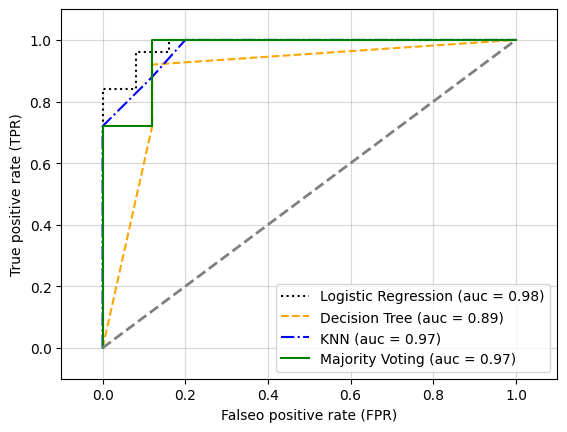

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']


for clf, label, clr, ls in zip(all_clf,
                               clf_labels,
                               colors,
                               linestyles):
  y_pred = clf.fit(X_train,
                   y_train).predict_proba(X_test)[:, 1]

  fpr, tpr, threshold = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)

  plt.plot(fpr, tpr,
           color=clr,
           linestyle=ls,
           label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(alpha=0.5)
plt.xlabel('Falseo positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [ ]:
# standardize training features for plotting decision boundary
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

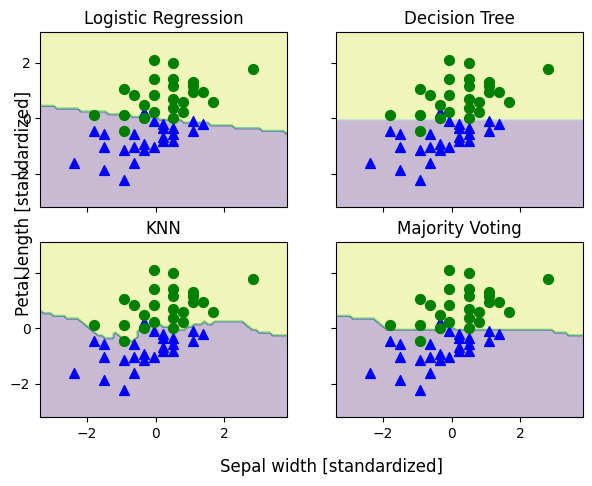

In [ ]:
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2,
                        ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf,
                        clf_labels):
  clf.fit(X_train_std, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

  axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                X_train_std[y_train == 0, 1],
                                c='blue',
                                marker='^',
                                s=50)

  axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                X_train_std[y_train == 1, 1],
                                c='green',
                                marker='o',
                                s=50)

  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.0,
         s='Sepal width [standardized]',
         ha='center',
         va='center',
         fontsize=12)

plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center',
         va='center',
         fontsize=12,
         rotation=90)
plt.show()

In [ ]:
# view individual parameters inside GridSearch object
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()), ['clf', LogisticRegression(C=0.1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=3),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()), ['clf', KNeighborsClassifier()]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.1,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__multi_class': 'deprecated',
 'pipeline-1__clf__n_jobs': None,
 'pipeline-1__clf__p

In [ ]:
# tune inverse regularization param C of LogReg classifier
# and decision tree depth via GridSearchCV
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2, 3],
          'pipeline-1__clf__C': [0.001, 0.01, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=3),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier()]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3],
                         'pipeline-1__clf__C': [0.001, 0.01, 100.0]},
             scoring='roc_auc')

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.05363281, 0.01657889, 0.04893842, 0.0436367 , 0.00694005,
        0.0091136 , 0.00864687, 0.00692697, 0.01232238]),
 'std_fit_time': array([0.04505936, 0.00790561, 0.03181984, 0.03388836, 0.00024423,
        0.00407064, 0.00409177, 0.00023274, 0.01091241]),
 'mean_score_time': array([0.01902366, 0.00853562, 0.01050265, 0.00892527, 0.00486426,
        0.00542576, 0.00398262, 0.00411711, 0.00670111]),
 'std_score_time': array([0.01170641, 0.00390045, 0.0075353 , 0.00495303, 0.00257892,
        0.00307079, 0.00109735, 0.00096005, 0.00683263]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=999999),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.01, 100.0, 0.001, 0.01, 100.0, 0.001, 0.01,
                    100.0],
              mask=[False, False, False, False, False, False, False, False

In [ ]:
grid.cv_results_['mean_test_score'],  grid.cv_results_['std_test_score']

(array([0.96666667, 0.96666667, 0.95      , 0.96666667, 0.96666667,
        0.95      , 0.96666667, 0.96666667, 0.95      ]),
 array([0.1       , 0.1       , 0.10671874, 0.1       , 0.1       ,
        0.10671874, 0.1       , 0.1       , 0.10671874]))

In [ ]:
# print different hyperparameter value combination
# and average ROC AUC scores computed via 10-fold CV
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  mean_score = grid.cv_results_['mean_test_score'][r]
  std_dev = grid.cv_results_['std_test_score'][r]
  params = grid.cv_results_['params'][r]
  print(f'{mean_score:.3f} (+/-{std_dev:.3f}) for {params}')

0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.950 (+/-0.107) for {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.950 (+/-0.107) for {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
0.967 (+/-0.100) for {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.01}
0.950 (+/-0.107) for {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100.0}


In [ ]:
print(f'Best param: {grid.best_params_}\n'
      f'ROC AUC: {grid.best_score_:.3f}')

Best param: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.967


In [ ]:
grid.predict(X_test)

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0])

In [ ]:
grid.score(X_test, y_test)

np.float64(0.9728000000000001)

In [ ]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1),
 Pipeline(steps=[('sc', StandardScaler()), ['clf', KNeighborsClassifier()]])]

In [ ]:
grid.best_estimator_.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()), ['clf', KNeighborsClassifier()]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__multi_class': 'deprecated',
 'pipeline-1__clf__n_jobs': None,
 'pipeline-1

In [ ]:
mv_clf = grid.best_estimator_

# unpack dictionary of best hyperparams found by GridSearchCV
# using (**) syntax and pass to set_params()
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier())])])

## Bagging -building an ensemble of classifiers from bootstrap samples

### Applying bagging to classify examples in the Wine dataset

In [ ]:
# create a more complex classification problem using Wine dataset
# use only classes 2 and 3, and select two features
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                     'machine-learning-databases/wine/wine.data',
                     header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
              'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

# extract featuers and labels
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

In [ ]:
# encode labels to 0 and 1 from 2 and 3
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

In [ ]:
# use an unpruned decision tree as base classifier
# and create and ensemble of 500 decision trees
# to fit different boostrap samples
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None) # unpruned

bag = BaggingClassifier(estimator=tree,
                        n_estimators=1000,
                        max_samples=0.8, # only 80% of training samples
                        max_features=1.0, # all features
                        bootstrap=False, # with replacement
                        bootstrap_features=False,
                        n_jobs=-1)

bag

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(criterion='entropy'),
                  max_samples=0.8, n_estimators=1000, n_jobs=-1)

In [ ]:
# calculate pred score on training and test datasets
# to compare performance of bagging classifier to
# unpruned decision tree
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test acc: {tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print(f'Bagging train/test acc: {bag_train:.3f}/{bag_test:.3f}')

Decision tree train/test acc: 1.000/0.833
Bagging train/test acc: 1.000/0.833


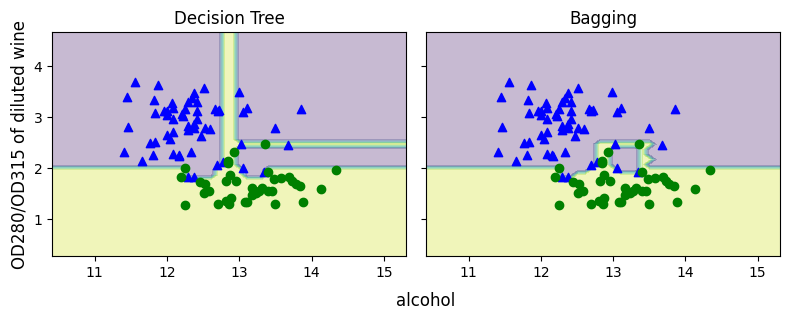

In [ ]:
# compare decision regions between decision tree and bagging
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1,
                       ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
  clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=0.3)

  axarr[idx].scatter(X_train[y_train == 0, 0],
                     X_train[y_train == 0, 1],
                     c='blue',
                     marker='^')

  axarr[idx].scatter(X_train[y_train == 1, 0],
                     X_train[y_train == 1, 1],
                     c='green',
                     marker='o')

  axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wine',
                    fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

## Leveraging weak learners via adaptive boosting

### How Adaptive Boosting works

In [ ]:
# follow calculation step by step
# start by computing the weighted error rate epsilon
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = y == yhat
weights = np.full(10, 0.1)
correct, weights

(array([ True,  True,  True,  True,  True,  True, False, False, False,
         True]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [ ]:
# invert correct from T --> F
correct, ~correct

(array([ True,  True,  True,  True,  True,  True, False, False, False,
         True]),
 array([False, False, False, False, False, False,  True,  True,  True,
        False]))

In [ ]:
# compute the proportion of incorrect predictions
epsilon = np.mean(~correct)
epsilon

np.float64(0.3)

In [ ]:
# compute coeffcient used to update weights
alpha_j = 0.5 * np.log((1 - epsilon) / epsilon)
alpha_j

np.float64(0.42364893019360184)

In [ ]:
# update weight vector uisng: w:= w * exp(-alpha_j x yhat x y)
# `yhat x y` is an element-wise multiplication between vectors
# of predicted and true class labels
# if a prediction, yhat, is correct, `yhat x y` will have a positive sign
# that decreases the ith weight, since alpha_j is positive
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
update_if_correct

np.float64(0.06546536707079771)

In [ ]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
update_if_wrong_1

np.float64(0.1527525231651947)

In [ ]:
# assign `update_if_correct` value to all correct preds
# and `update_if_wrong` value to all wrong preds
weights = np.where(correct == 1,
                   update_if_correct,
                   update_if_wrong_1)
weights

array([0.06546537, 0.06546537, 0.06546537, 0.06546537, 0.06546537,
       0.06546537, 0.15275252, 0.15275252, 0.15275252, 0.06546537])

In [ ]:
# normalize weights so they sum up to w
weights_norm = weights / np.sum(weights)
weights_norm, weights_norm.sum()

(array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.16666667, 0.16666667, 0.16666667, 0.07142857]),
 np.float64(0.9999999999999999))

### Applying AdaBoost using scikit-learn

In [ ]:
# train a bagging meta-classifier with Wine dataset
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# create a decision tree stump by setting max_depth=1
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=5000,
                         learning_rate=0.1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test acc: {tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f'AdaBoost train/test acc: {ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test acc: 0.926/0.833
AdaBoost train/test acc: 1.000/0.833


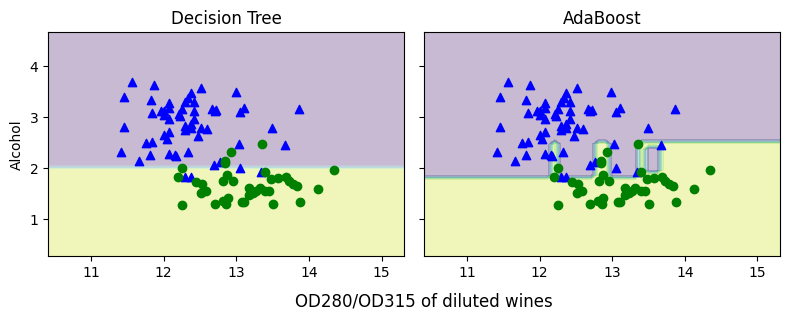

In [ ]:
# plot decision boundary
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1,
                        ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3)
                        )

for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
  clf = clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=0.3)

  axarr[idx].scatter(X_train[y_train == 0, 0],
                     X_train[y_train == 0, 1],
                     c='blue',
                     marker='^')

  axarr[idx].scatter(X_train[y_train == 1, 0],
                     X_train[y_train == 1, 1],
                     c='green',
                     marker='o')

  axarr[idx].set_title(tt)
  axarr[0].set_ylabel('Alcohol')

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

## Gradient Boosting - training an ensemble based on loss gradients

### XGBoost

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.01,
                          max_depth=4)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)

print(f'XGBoost train/test acc: {gbm_train:.3f}/{gbm_test:.3f}')

XGBoost train/test acc: 0.979/0.875


In [ ]:
xx.ravel()[:5], yy.ravel()[:5]

(array([10.41, 10.51, 10.61, 10.71, 10.81]),
 array([0.27, 0.27, 0.27, 0.27, 0.27]))

In [ ]:
np.c_[xx.ravel(), yy.ravel()][:5]

array([[10.41,  0.27],
       [10.51,  0.27],
       [10.61,  0.27],
       [10.71,  0.27],
       [10.81,  0.27]])

# Chapter 8 - Sentiment Analysis

Topics:

* Cleaning and preparng text data
* Building feature vectors from text documents
* Training a machine learning model to classifty positive and negatie movie reviews
* Wokring with large text datasets using out-of-score learning
* Inferring topics from document collections for categorization

In [ ]:
# add folder to path to load from check_packages.py script
import sys

sys.path.insert(0, '..')

# check recommended package version
try:
  from python_environment_check import check_packages
except:
  !wget https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/python_environment_check.py
  from python_environment_check import check_packages

--2025-08-05 22:58:15--  https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1815 (1.8K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.77K  --.-KB/s    in 0s      

2025-08-05 22:58:15 (30.0 MB/s) - ‘python_environment_check.py’ saved [1815/1815]

[OK] Your Python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
d = {
    'numpy': '1.21.2',
    'pandas': '1.3.2',
    'sklearn': '1.0',
    'pyprind': '2.11.3',
    'nltk': '3.6'
}

check_packages(d)

[FAIL]: pyprind is not installed and/or cannot be imported.
[OK] numpy 2.0.2
[OK] pandas 2.2.2
[OK] sklearn 1.6.1
[OK] nltk 3.9.1


## Preparing the IMDb movie review data for text preprocessing

In [ ]:
# download and unzip dataset
import os
import sys
import tarfile
import time
import urllib.request as req

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

if os.path.exists(target):
  os.remove(target)

def reporthook(count, block_size, total_size):
  global start_time

  if count == 0:
    start_time = time.time()
    return

  duration = time.time() - start_time
  progress_size = int(count * block_size)

  speed = progress_size / (1024.0 ** 2 * duration)
  percent = count * block_size * 100.0 / total_size

  sys.stdout.write(f'\r{int(percent)}% | {progress_size / (1024.0 ** 2)} MB'
          f' | {speed:.2f} MB/s | {duration:.2f} sec elapsed')

if not os.path.isdir('aclImdb') \
  and not os.path.isfile('aclImdb_v1.targ.gz'):
  req.urlretrieve(source, target, reporthook)

100% | 80.234375 MB | 19.99 MB/s | 4.01 sec elapsed

In [ ]:
if not os.path.isdir('aclImdb'):
  with tarfile.open(target, 'r:gz') as tar:
    tar.extractall()

### Preprocessing movie dataset into a more convenient format

In [ ]:
 # install PyPrind to visual progress and time estimated
 # for reading movie reviews into a pandas DataFrame

! pip install pyprind -q

In [ ]:
import pyprind
import pandas as pd
import os
import sys
from packaging import version

# change `basepath` to dir of unzipped movie dataset
basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000, stream=2)

df = pd.DataFrame()

for s in ('test', 'train'):
  for l in ('pos', 'neg'):
    path = os.path.join(basepath, s, l)
    for file in sorted(os.listdir(path)):
      with open(os.path.join(path, file), 'r',
                encoding='utf-8') as infile:
        txt = infile.read()

      if version.parse(pd.__version__) >= version.parse('1.3.2'):
        x = pd.DataFrame([[txt, labels[l]]],
                         columns=['review', 'sentiment'])
        df = pd.concat([df, x],
                       ignore_index=True)

      else:
        df = df.append([[txt, labels[l]]],
                       ignore_index=True)

      pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:05


In [ ]:
df

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
...,...,...
49995,"Towards the end of the movie, I felt it was to...",0
49996,This is the kind of movie that my enemies cont...,0
49997,I saw 'Descent' last night at the Stockholm Fi...,0
49998,Some films that you pick up for a pound turn o...,0


In [ ]:
df.index

RangeIndex(start=0, stop=50000, step=1)

In [ ]:
# shuffle sorted dataset saved in DataFrame
import numpy as np

if version.parse(pd.__version__) >= version.parse('1.3.2'):
  df = df.sample(frac=1,
                 random_state=1).reset_index(drop=True)
else:
  df = df.reindex(np.random.permutation(df.index))

In [ ]:
df

,review,sentiment
0,"When we started watching this series on cable,...",1
1,Steve Biko was a black activist who tried to r...,1
2,My short comment for this flick is go pick it ...,1
3,"As a serious horror fan, I get that certain ma...",0
4,"Robert Cummings, Laraine Day and Jean Muir sta...",1
...,...,...
49995,Every generation fully believes it is living i...,0
49996,Possibly the most brilliant thing about Che: P...,1
49997,I was unsure of this movie before renting and ...,1
49998,"Just got out of an advance screening, and wow ...",1


In [ ]:
df.to_csv('movie_data.csv',
          index=False,
          encoding='utf-8')

## Bag-of-word model

### Transforming words into feature vectors

In [ ]:
# construct a bag-of-words model based on word counts
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining, the weather is sweet, and one and one is two'
])

bag = count.fit_transform(docs)
bag.toarray()

array([[0, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 1],
       [2, 3, 2, 1, 1, 1, 2, 1, 1]])

In [ ]:
count.vocabulary_

{'the': 6,
 'sun': 4,
 'is': 1,
 'shining': 3,
 'weather': 8,
 'sweet': 5,
 'and': 0,
 'one': 2,
 'two': 7}

### Assessing word relevancy via term frequency-inverse document frequency

In [ ]:
np.set_printoptions(precision=2)

In [ ]:
# implement tf-idf from scikit-learn
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

tfidf.fit_transform(count.fit_transform(docs)).toarray()

array([[0.  , 0.43, 0.  , 0.56, 0.56, 0.  , 0.43, 0.  , 0.  ],
       [0.  , 0.43, 0.  , 0.  , 0.  , 0.56, 0.43, 0.  , 0.56],
       [0.5 , 0.45, 0.5 , 0.19, 0.19, 0.19, 0.3 , 0.25, 0.19]])

In [ ]:
# calculate tf-idf of the word "is" in 3rd document
tf_is = 3
n_docs = 3
idf_is = np.log((n_docs + 1) / (3 + 1))
tfidf_is = tf_is * (idf_is + 1)
print(f'tf-idf of term "is" - {tfidf_is:.2f}')

tf-idf of term "is" - 3.00


In [ ]:
# obtain raw td-idf of feature vector
tfidf = TfidfTransformer(use_idf=True,
                         norm=None,
                         smooth_idf=True)

raw_tfidf = tfidf.fit_transform(count.fit_transform(docs)).toarray()[-1]
raw_tfidf

array([3.39, 3.  , 3.39, 1.29, 1.29, 1.29, 2.  , 1.69, 1.29])

In [ ]:
tfidf.fit_transform(count.fit_transform(docs)).toarray()

array([[0.  , 1.  , 0.  , 1.29, 1.29, 0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 1.29, 1.  , 0.  , 1.29],
       [3.39, 3.  , 3.39, 1.29, 1.29, 1.29, 2.  , 1.69, 1.29]])

In [ ]:
# apply L2 normalization
l2_tfidf = raw_tfidf / np.sqrt(np.sum(raw_tfidf ** 2))
l2_tfidf

array([0.5 , 0.45, 0.5 , 0.19, 0.19, 0.19, 0.3 , 0.25, 0.19])

### Cleaning text data

In [ ]:
# display last 50 chars from a doc from shuffled dataset
df.loc[100, 'review'][-50:]

"captures Simon's heart.<br /><br />Very enjoyable."

In [ ]:
# remove all punctuation marks but leave emoticons
import re

def preprocessor(text):
  text = re.sub('<[^>]*>', '', text) # remove html markup
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                         text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', ''))
  return text

In [ ]:
preprocessor(df.loc[100, 'review'][-50:])

'captures simon s heart very enjoyable '

In [ ]:
preprocessor("</a>This :) is a :( test :-)!")

'this is a test :) :( :)'

In [ ]:
# apply preprocessor function to all movie reviews
df['review'] = df['review'].apply(preprocessor)
df.loc[100, 'review'][-50:]

'e woman who captures simon s heart very enjoyable '

### Processing documents into tokens

In [ ]:
# tokenize document by splitting them into individual words
def tokenizer(text):
  return text.split()

ex = 'runners like running and thus they run'
tokenizer(ex)

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [ ]:
# install Natural Language Toolkit (NLTK)
# to use implementation of Porter stemming algorithm
!pip install nltk -q

In [ ]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

tokenizer_porter(ex)

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [ ]:
# use set of 127 English stop words from NLTK
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load and apply stop word set
from nltk.corpus import stopwords

stop = stopwords.words('english')

[w for w in tokenizer_porter(ex) if w not in stop]

['runner', 'like', 'run', 'thu', 'run']

## Training a logistic regression model for document classification

In [ ]:
# divide Dataframe of cleaned text document into
# 25k docs for training and testing
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [ ]:
# use a GridSearchCv object to find optimal set of params
# for logistic regression model using 5-fold cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf': [False],
                     'vect__norm': [None],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]}
                    ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(estimator=lr_tfidf,
                           param_grid=small_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [ ]:
# train mode
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x7fe8f16d6b60>,
                                              <function tokenizer_porter at 0x7fe8f16d5ee0...
                          'vect__stop_words': [['a', 'about', 'above', 'after',
                                                'again', 'against', 'ain',
                                                'all', 'am', 'an', 'and', 'any',
                                                'are', 'aren', "aren't", 'as',
                                                'at', 'be', 'because', 'been',
                                                'before', 'being', 'below',
                                                'between', 'both', 'but', 'by',
                                                'can', 'couldn', "couldn't", ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x7fe8f16d6b60>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

In [ ]:
gs_lr_tfidf.best_params_

{'clf__C': 10.0,
 'clf__penalty': 'l2',
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.tokenizer(text)>}

In [ ]:
gs_lr_tfidf.best_score_

np.float64(0.8963640311937613)

In [ ]:
gs_lr_tfidf.score(X_test, y_test)

0.89792

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(0)
np.set_printoptions(precision=6)

# create random int representing class labels
y = [np.random.randint(3) for i in range(25)]
X = (y + np.random.randn(25)).reshape(-1, 1)

cv5_idx = list(StratifiedKFold(n_splits=5,
                              shuffle=False).split(X, y))

lr = LogisticRegression()

cross_val_score(estimator=lr,
                X=X,
                y=y,
                cv=cv5_idx)

array([0.6, 0.4, 0.6, 0.2, 0.6])

In [ ]:
cv5_idx

[(array([ 4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24]),
  array([0, 1, 2, 3, 5])),
 (array([ 0,  1,  2,  3,  5,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24]),
  array([ 4,  6,  7,  8, 12])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15, 18, 19, 20, 21,
         22, 23, 24]),
  array([ 9, 10, 11, 16, 17])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 17, 21,
         22, 23, 24]),
  array([13, 15, 18, 19, 20])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
         18, 19, 20]),
  array([14, 21, 22, 23, 24]))]

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()

gs = GridSearchCV(estimator=lr,
                  param_grid={},
                  cv=cv5_idx,
                  verbose=3).fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.600 total time=   0.0s
[CV 2/5] END ..................................., score=0.400 total time=   0.0s
[CV 3/5] END ..................................., score=0.600 total time=   0.0s
[CV 4/5] END ..................................., score=0.200 total time=   0.0s
[CV 5/5] END ..................................., score=0.600 total time=   0.0s


## Working with bigger data - online algorithms and out-of-core learning

In [ ]:
# define a tokenizer function that cleans unprocessed text
# from movie_data.csv file constructed previously
# then separate it into word tokens while removing stop words
import numpy as np
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')

def tokenizer(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                         text)
  text = re.sub('[]W]+', ' ', text.lower()) \
          + ' '.join(emoticons).replace('-', '')
  tokenized = [w for w in text.split() if w not in stop]
  return tokenized


In [ ]:
# define a generator function that reads in and
# returns one document at a time
def stream_docs(path):
  with open(path, 'r', encoding='utf-8') as csv:
    next(csv) # skip header
    for line in csv:
      text, label = line[:-3], int(line[-2])
      yield text, label


In [ ]:
# verify function works
text, label = next(stream_docs(path='movie_data.csv'))
text, label

('"When we started watching this series on cable, I had no idea how addictive it would be. Even when you hate a character, you hold back because they are so beautifully developed, you can almost understand why they react to frustration, fear, greed or temptation the way they do. It\'s almost as if the viewer is experiencing one of Christopher\'s learning curves.<br /><br />I can\'t understand why Adriana would put up with Christopher\'s abuse of her, verbally, physically and emotionally, but I just have to read the newspaper to see how many women can and do tolerate such behavior. Carmella has a dream house, endless supply of expensive things, but I\'m sure she would give it up for a loving and faithful husband - or maybe not. That\'s why I watch.<br /><br />It doesn\'t matter how many times you watch an episode, you can find something you missed the first five times. We even watch episodes out of sequence (watch season 1 on late night with commercials but all the language, A&E with la

In [ ]:
tokenizer(text)

['"when',
 'started',
 'watching',
 'series',
 'cable,',
 'idea',
 'addictive',
 'would',
 'be.',
 'even',
 'hate',
 'character,',
 'hold',
 'back',
 'beautifully',
 'developed,',
 'almost',
 'understand',
 'react',
 'frustration,',
 'fear,',
 'greed',
 'temptation',
 'way',
 'do.',
 'almost',
 'viewer',
 'experiencing',
 'one',
 "christopher's",
 'learning',
 'curves.i',
 "can't",
 'understand',
 'adriana',
 'would',
 'put',
 "christopher's",
 'abuse',
 'her,',
 'verbally,',
 'physically',
 'emotionally,',
 'read',
 'newspaper',
 'see',
 'many',
 'women',
 'tolerate',
 'behavior.',
 'carmella',
 'dream',
 'house,',
 'endless',
 'supply',
 'expensive',
 'things,',
 'sure',
 'would',
 'give',
 'loving',
 'faithful',
 'husband',
 '-',
 'maybe',
 'not.',
 "that's",
 'watch.it',
 'matter',
 'many',
 'times',
 'watch',
 'episode,',
 'find',
 'something',
 'missed',
 'first',
 'five',
 'times.',
 'even',
 'watch',
 'episodes',
 'sequence',
 '(watch',
 'season',
 '1',
 'late',
 'night',
 'com

In [ ]:
# define a function that takes a doc stream
# and returns a particular number of docs specified
def get_minibatch(doc_stream, size):
  docs, y = [], []
  try:
    for _ in range(size):
      text, label = next(doc_stream)
      docs.append(text)
      y.append(label)
  except StopIteration:
    return None, None
  return docs, y


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)


In [ ]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

clf = SGDClassifier(loss='log_loss',
                    random_state=1)

doc_stream = stream_docs(path='movie_data.csv')

In [ ]:
# start out-of-core learning
import pyprind

pbar = pyprind.ProgBar(45)
classes = np.array([0, 1])

for _ in range(45):
  X_train, y_train = get_minibatch(doc_stream, size=1000)

  if not X_train:
    break

  X_train = vect.transform(X_train)
  clf.partial_fit(X=X_train,
                  y=y_train,
                  classes=classes)
  pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35


In [ ]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)

print(f'Test acc: {clf.score(X_test, y_test):.3f}')

Test acc: 0.857


In [ ]:
# use last 5000 docs to evaluate model performance
clf = clf.partial_fit(X_test, y_test)
clf.score(X_test, y_test)

0.8784

## Topic modeling with Latent Dirichlet Allocation

### LDA with scikit-learn

In [ ]:
import pandas as pd

df = pd.read_csv('movie_data.csv',
                 encoding='utf-8')
df.head()

,review,sentiment
0,"When we started watching this series on cable,...",1
1,Steve Biko was a black activist who tried to r...,1
2,My short comment for this flick is go pick it ...,1
3,"As a serious horror fan, I get that certain ma...",0
4,"Robert Cummings, Laraine Day and Jean Muir sta...",1


In [ ]:
# creata bag-of-word matrix as input to LDA
# use English stop word library from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english',
                        max_df=0.1, # max doc frequency of words / 10%
                        max_features=5000) # num of words most frequent

X = count.fit_transform(df['review'].values)
X.shape

(50000, 5000)

In [ ]:
# fit a LDA estimator to bag-of-word matrix and
# infer 10 different topics from documents
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123,
                                learning_method='batch') # train on all data

X_topics = lda.fit_transform(X)

In [ ]:
# inspect matric containing word importance
lda.components_

array([[6.688383e+00, 8.175706e+01, 9.404351e+01, ..., 1.156216e+03,
        8.037670e+02, 5.449682e+01],
       [1.204978e+02, 1.798812e+02, 3.197526e+02, ..., 1.941020e+01,
        1.719994e+01, 8.458579e+00],
       [1.000893e-01, 4.273493e+01, 3.210185e+01, ..., 2.188169e-01,
        1.000173e-01, 1.000162e-01],
       ...,
       [1.588684e+01, 1.686495e+02, 3.567987e+01, ..., 5.269861e-01,
        2.214974e+00, 6.532174e+01],
       [3.256293e+00, 3.080990e+01, 3.438232e+01, ..., 1.000049e-01,
        1.000027e-01, 1.000183e-01],
       [1.921534e+01, 2.857492e+00, 1.250962e+02, ..., 1.000059e-01,
        1.000054e-01, 9.118662e+00]])

In [ ]:
lda.components_.shape

(10, 5000)

In [ ]:
# print five most important words for each of 10 topics
# word importance values are ranked in increasing order
# so we need to sort topic array in reverse order
n_top_words = 5
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
  print(f'Topic P{topic_idx + 1}:')
  print(' '.join([feature_names[i]
                  for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic P1:
horror effects budget special gore
Topic P2:
guy money worst minutes stupid
Topic P3:
action version english japanese match
Topic P4:
book read feel audience game
Topic P5:
series tv episode shows episodes
Topic P6:
family woman father mother girl
Topic P7:
music musical role performance song
Topic P8:
war police men murder action
Topic P9:
role script comedy actor performance
Topic P10:
comedy action watched fun original


In [ ]:
# confirm categories makes sense based on reviews
thriller = X_topics[:, 7].argsort()[::-1]

for iter_idx, movie_idx in enumerate(thriller[:3]):
  print(f'Horror movie #{iter_idx + 1}:')
  print(df['review'][movie_idx][:300], '...')

Horror movie #1:
It's true that "They Died With Their Boots On" gives a highly fictionalized account of George Armstrong Custer's (Errol Flynn) life and career, but a remarkable one, especially with regard to the Battle of the Little Big Horn. Because it is not a given that a 1941 movie tries to portray both the US- ...
Horror movie #2:
This movie lacked credibility for two reasons. One, no mayor of a major city, and New York is certainly as major as it gets. Would allow a borough in his city to degenerate into such a violent place to live; especially for voters who could have much to say about his or her future job security. All o ...
Horror movie #3:
If you believe that any given war movie can make you really feel the war, you need to see "Letyat zhuravli" (called "The Cranes are Flying" in English). It tells the story of Veronika (Tatiana Samoylova) and Boris (Aleksey Batalov), who are in love on the verge of WWII. They are walking along the wa ...


# Chapter 9 - Regression Analysis

Topics:

* Exploring and visualizing datasets
* Looking at different approaches to implementing linear regression modesl
* Training regression models that are robust to outliers
* Evaluating regression models and diagnosing common problems
* Fitting regression models to nonlinear data

## Using Ames Housing dataset

In [ ]:
import pandas as pd
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [ ]:
df.shape

(2930, 6)

In [ ]:
# encode values for column Central Air
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y':1})
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


In [ ]:
# check missing values
df.isnull().sum()

,0
Overall Qual,0
Overall Cond,0
Total Bsmt SF,1
Central Air,0
Gr Liv Area,0
SalePrice,0


In [ ]:
# drop row with missing value
df = df.dropna(axis=0)
df.isnull().sum()

,0
Overall Qual,0
Overall Cond,0
Total Bsmt SF,0
Central Air,0
Gr Liv Area,0
SalePrice,0


### Visualize important characteristics of a dataset

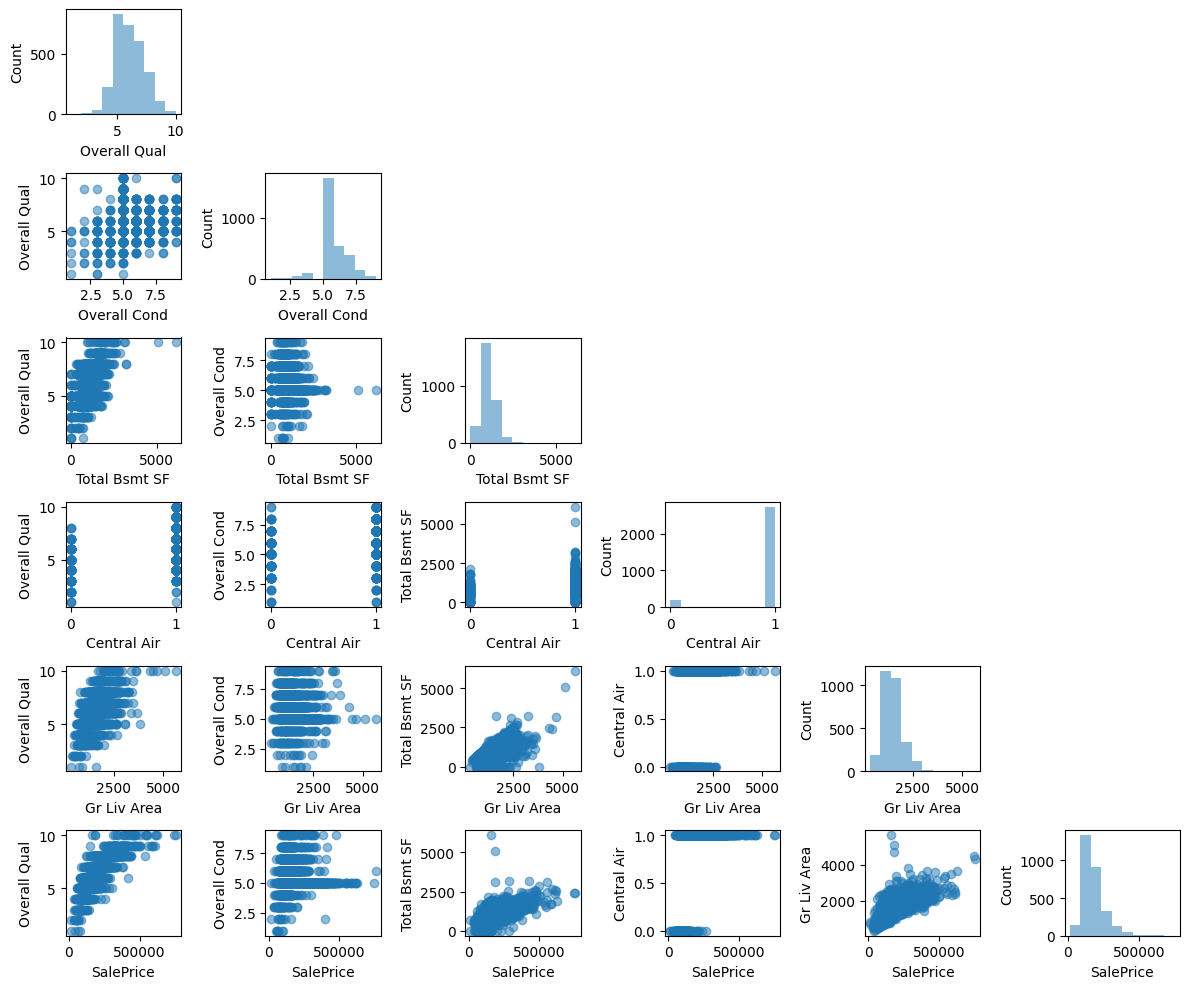

In [ ]:
# create a scatterplot matrix to visualize pair-wise
# correlations between different features
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values,
                  figsize=(12, 10),
                  names=df.columns,
                  alpha=0.5)

plt.tight_layout()
plt.show()

### Looking at relationships using a correlation matrix

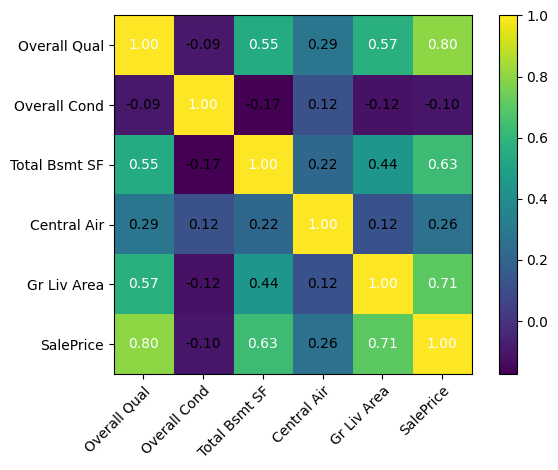

In [ ]:
# use NumPy's corrcoef function on five feature columns
# and mlxtend's heatmap function to plot correlation matrix
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm,
             row_names=df.columns,
             column_names=df.columns)

plt.tight_layout()
plt.show()

## Implementing an *Ordinary Least Squared* (OLS) linear regression model

### Solving regression for regression parameters with gradient descent

In [ ]:
# implemt a linear regression model
# based on Adaline class (without threshold function)

class LinearRegressionGD:
  def __init__(self,
               eta=0.01,
               n_iter=50,
               random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0,
                          scale=0.01,
                          size=X.shape[1])
    self.b_ = np.array([0.])
    self.losses_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)
      errors = (y - output)
      self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
      self.b_ += self.eta * 2.0 * errors.mean()
      loss = (errors ** 2).mean()
      self.losses_.append(loss)

    return self

  def net_input(self, X):
    return np.dot(X, self.w_) + self.b_

  def predict(self, X):
    return self.net_input(X)


In [ ]:
# extract and standardize col `Overall Qual` as training faeture
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X = df[['Overall Qual']].values
y = df['SalePrice'].values

X_std = sc_x.fit_transform(X)

# StandardScalers takes 2D array as arg
# so need to turn y from 1D to 2D first using np.newaxis
# and then convert back to 1D using flatten()
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

X[:5], X_std[:5], y[:5], y_std[:5]

(array([[6],
        [5],
        [6],
        [7],
        [5]]),
 array([[-0.06777463],
        [-0.77674566],
        [-0.06777463],
        [ 0.6411964 ],
        [-0.77674566]]),
 array([215000, 105000, 172000, 244000, 189900]),
 array([ 0.42783926, -0.94949293, -0.11057241,  0.79095411,  0.1135571 ]))

In [ ]:
ex = np.array([[1, 1],
               [2, 2]])
ex

array([[1, 1],
       [2, 2]])

In [ ]:
ex[:,:, np.newaxis], ex[:, :, np.newaxis].shape

(array([[[1],
         [1]],
 
        [[2],
         [2]]]),
 (2, 2, 1))

In [ ]:
ex.flatten()

array([1, 1, 2, 2])

In [ ]:
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

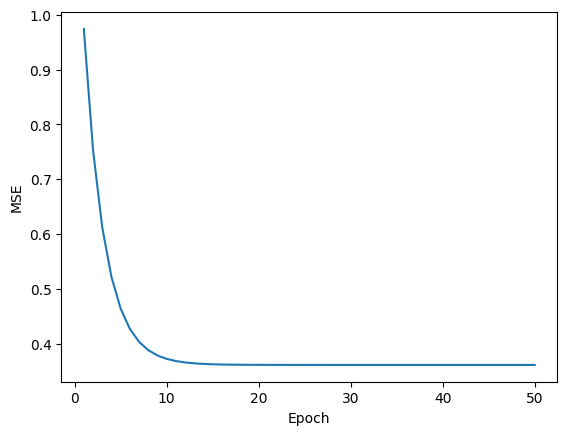

In [ ]:
# plt loss as a function of number of epochs (complte iterations)
# over training dataset when using algorithm such as GD
# to check that algorithm converged to a loss minimum
plt.plot(range(1, lr.n_iter+1),
         lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

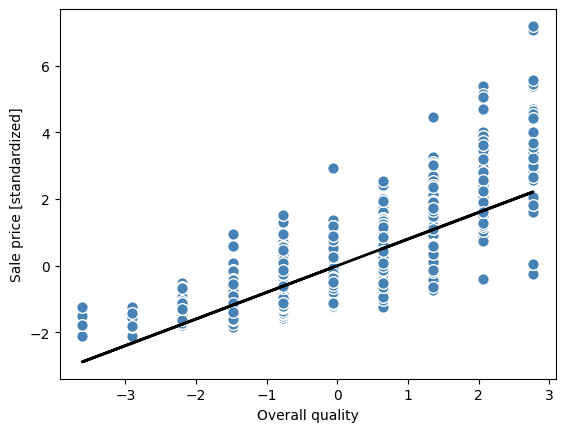

In [ ]:
# define a simple helper function to plot a scatterplot
# of training examples and add regression line
def lin_regplot(X, y, model):
  plt.scatter(X, y,
              c='steelblue',
              edgecolor='white',
              s=70)
  plt.plot(X,
           model.predict(X),
           color='black',
           lw=2)

lin_regplot(X_std, y_std, lr)
plt.xlabel('Overall quality')
plt.ylabel('Sale price [standardized]')
plt.show()

In [ ]:
# scale predicted price back onto original price in US dollars
feature_std = sc_x.transform(np.array([[8]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(1, -1))

target_reverted.flatten()[0]

np.float64(267001.0649932738)

In [ ]:
print(f'Slope: {lr.w_[0]:.3f}\n'
      f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.799
Intercept: -0.000


In [ ]:
# Let's try training on `Gr Liv Area`
X = df[['Gr Liv Area']].values
y= df['SalePrice'].values

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

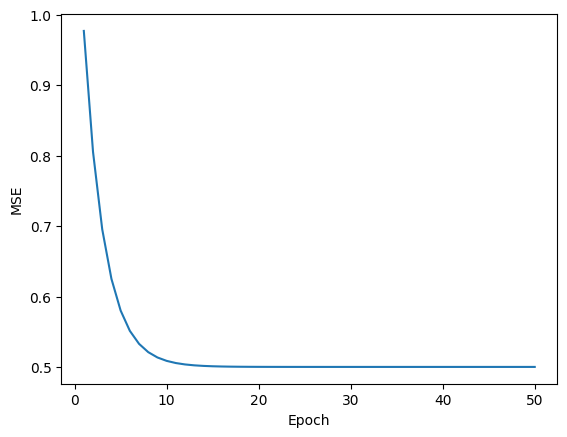

In [ ]:
lr = LinearRegressionGD(eta=0.1,
                        n_iter=50)
lr.fit(X_std, y_std)

# plot loss
plt.plot(range(1, lr.n_iter+1),
         lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

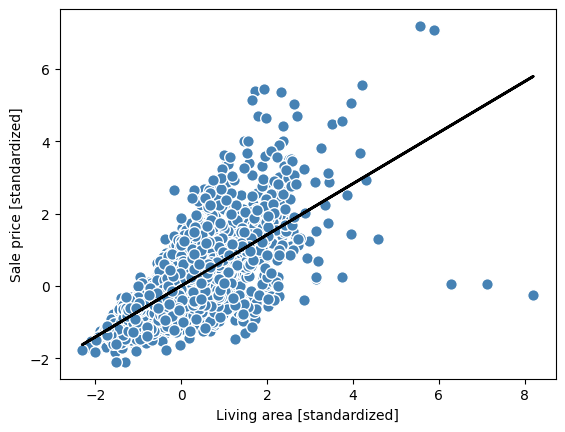

In [ ]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area [standardized]')
plt.ylabel('Sale price [standardized]')
plt.show()

In [ ]:
feature_std = sc_x.transform(np.array([[4800]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(1, -1))

target_reverted.flatten(), target_std

(array([549335.88043429]), array([4.61412627]))

### Estimating the coefficient of a regression model via scikit-learn


In [ ]:
# Linear regression implementation in scikit-learn works
# better with unstandardized variables, since it doesn't use
# (S)GD based optimization so we can skip standardization
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)

y_red = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}\n'
      f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


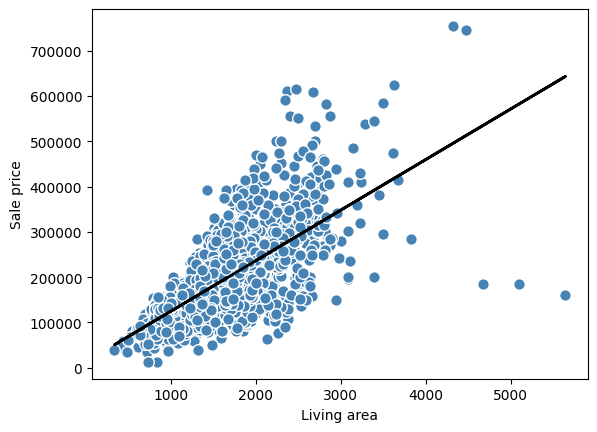

In [ ]:
# plot losses
lin_regplot(X, y, slr)
plt.xlabel('Living area')
plt.ylabel('Sale price')
plt.show()

In [ ]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

slr = LinearRegression()
slr.fit(X, y)

y_pred = slr.predict(X)

print(f'Slope: {slr.coef_[0]:.3f}\n'
      f'Intercept: {slr.intercept_:.3f}')

Slope: 45248.511
Intercept: -94985.815


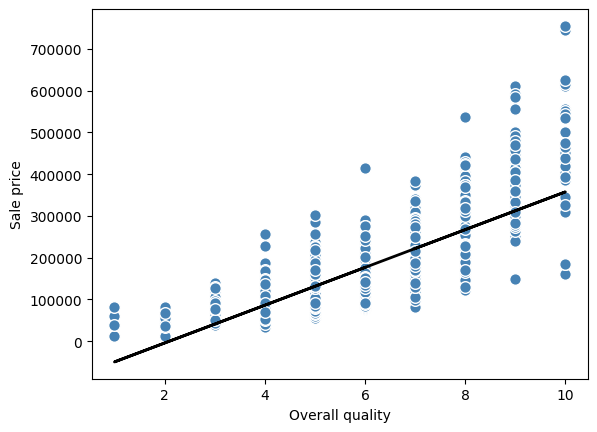

In [ ]:
lin_regplot(X, y, slr)
plt.xlabel('Overall quality')
plt.ylabel('Sale price')
plt.show()

## Fitting a robust regression model using RANSAC

In [ ]:
X = df['Gr Liv Area'].values[:, np.newaxis]
y = df['SalePrice'].values

In [ ]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(estimator=LinearRegression(),
                         max_trials=100,
                         min_samples=0.95,
                         residual_threshold=None)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95)

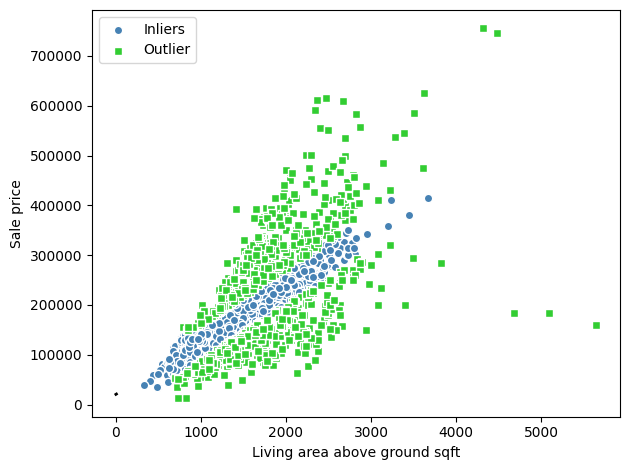

In [ ]:
# obtain inliers and outliers from fitted model
# and plot them with linear fit
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask],
            y[inlier_mask],
            c='steelblue',
            marker='o',
            edgecolor='white',
            label='Inliers')

plt.scatter(X[outlier_mask],
            y[outlier_mask],
            c='limegreen',
            edgecolor='white',
            marker='s',
            label='Outlier')

plt.plot(line_X,
         line_y_ransac,
         color='black',
         lw=2)

plt.xlabel('Living area above ground sqft')
plt.ylabel('Sale price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.337
Intercept: 20266.198


In [ ]:
# compute Mean Absolute Deviation for this dataset
def mean_absolute_deviation(data):
  return np.mean(np.abs(data - np.mean(data)))

mean_absolute_deviation(y)

np.float64(58269.561754979375)

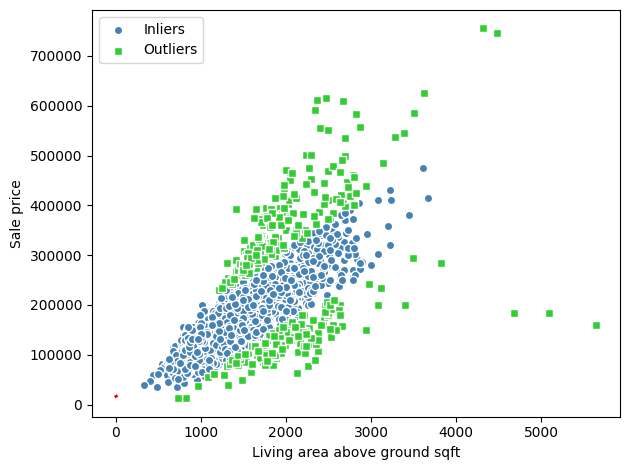

In [ ]:
# if we want to identify fewer data points as outliers,
# we can choose a `residual_threshold` value greater
# what is returned from `mean_absolute_deviation`
ransac1 = RANSACRegressor(estimator=LinearRegression(),
                          max_trials=100,
                          min_samples=0.95,
                          residual_threshold=75000)
ransac1.fit(X, y)

inlier_mask = ransac1.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac1.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask],
            y[inlier_mask],
            c='steelblue',
            edgecolor='white',
            marker='o',
            label='Inliers')

plt.scatter(X[outlier_mask],
            y[outlier_mask],
            c='limegreen',
            edgecolor='white',
            marker='s',
            label='Outliers')

plt.plot(line_X, line_y_ransac, color='red', lw=2)
plt.xlabel('Living area above ground sqft')
plt.ylabel('Sale price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
print(f'Slope: {ransac1.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac1.estimator_.intercept_:.3f}')

Slope: 107.108
Intercept: 16026.219


## Evaluating the performance of linear regression models

In [ ]:
# use all five features in dataset to train multiple models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [ ]:
# plot residuals
x_max = np.max(
    [np.max(y_train_pred), np.max(y_test_pred)]
)
x_min = np.min(
    [np.min(y_train_pred), np.min(y_test_pred)]
)

x_max, x_min

(np.float64(704003.5617210937), np.float64(-73950.20711392439))

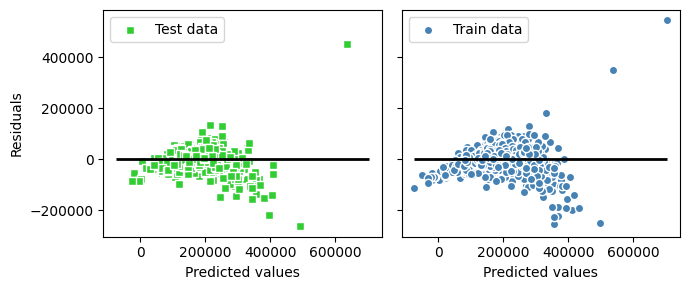

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(7, 3),
                               sharey=True)

ax1.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            marker='s',
            edgecolor='white',
            label='Test data')

ax2.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            marker='o',
            edgecolor='white',
            label='Train data')

ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
  ax.set_xlabel('Predicted values')
  ax.legend(loc='upper left')
  ax.hlines(y=0,
            xmin=x_min-100,
            xmax=x_max+100,
            color='black',
            lw=2)

plt.tight_layout()
plt.show()

In [ ]:
# MSE can be used for cross-validation and model selection
# MSE also normalizes according to sample size
# making it possible to compare across different sample sizes

# compute MSE from this training and test predictions
from sklearn.metrics import mean_squared_error as mse

mse_train = mse(y_train, y_train_pred)
mse_test = mse(y_test, y_test_pred)

mse_train, mse_test

(1502795480.1309607, 1493046326.069016)

In [ ]:
# compute MAE
from sklearn.metrics import mean_absolute_error as mae

mae_train = mae(y_train, y_train_pred)
mae_test = mae(y_test, y_test_pred)

mae_train, mae_test

(25760.575153114518, 25500.08109286091)

In [ ]:
# compute R^2
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_r2, test_r2

(0.767999428294523, 0.7561452416724377)

## Tuning a linear regression model into a curve-polynomial regression

### Adding polynomial terms using scikit-learn

In [ ]:
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])

In [ ]:
# 1. a second-degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)

X_quad = quadratic.fit_transform(X)
X_quad[:5], X[:5]


(array([[1.00000e+00, 2.58000e+02, 6.65640e+04],
        [1.00000e+00, 2.70000e+02, 7.29000e+04],
        [1.00000e+00, 2.94000e+02, 8.64360e+04],
        [1.00000e+00, 3.20000e+02, 1.02400e+05],
        [1.00000e+00, 3.42000e+02, 1.16964e+05]]),
 array([[258.],
        [270.],
        [294.],
        [320.],
        [342.]]))

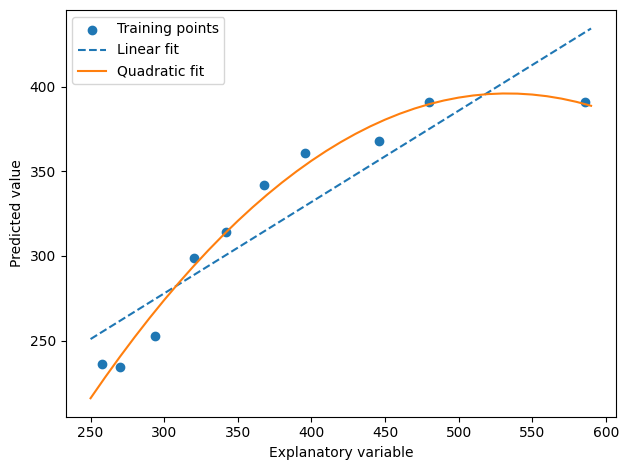

In [ ]:
# 2. fit a simple linear regression model for comparison
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 3. fit a multiple regression model on transformed features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='Training points')

# plot linear regression results
plt.plot(X_fit,
         y_lin_fit,
         label='Linear fit',
         linestyle='--')

# plot quadratic results
plt.plot(X_fit,
         y_quad_fit,
         label='Quadratic fit')

plt.xlabel('Explanatory variable')
plt.ylabel('Predicted value')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# compute MSE and R^2 evaluation metrics
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

mse_lin = mse(y, y_lin_pred)
mse_quad = mse(y, y_quad_pred)

print(f'Train MSE linear: {mse_lin:.2f}\n'
      f'Train MSE quad: {mse_quad:.2f}')

r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)

print(f'Train R2 linear: {r2_lin:.2f}\n'
      f'Train R2 quad: {r2_quad:.2f}')

Train MSE linear: 569.78
Train MSE quad: 61.33
Train R2 linear: 0.83
Train R2 quad: 0.98


## Modeling nonlinear relationships in the Ames Housing dataset

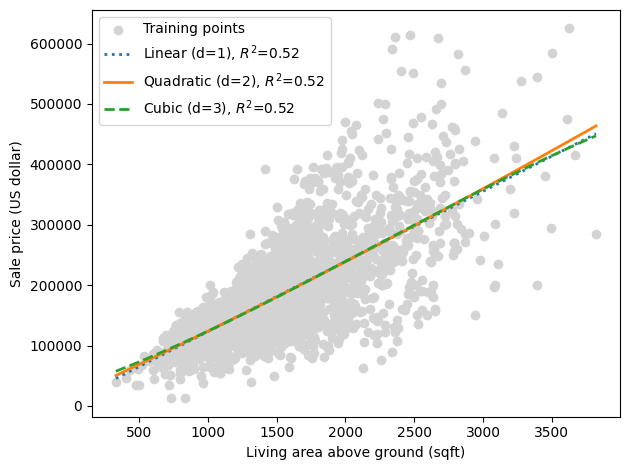

In [ ]:
# remove outliers with living area greater than 4,000 sqft
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]

# fit regression model
reg = LinearRegression()

# creat quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min() - 1,
                  X.max() + 2,
                  1)[:, np.newaxis]

reg.fit(X, y)
y_lin_pred = reg.predict(X_fit)
lin_r2 = r2_score(y, reg.predict(X))

reg = reg.fit(X_quad, y)
y_quad_pred = reg.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y, reg.predict(X_quad))

reg = reg.fit(X_cubic, y)
y_cubic_pred = reg.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, reg.predict(X_cubic))

# plot results
plt.scatter(X, y,
            label='Training points',
            color='lightgray')

plt.plot(X_fit,
         y_lin_pred,
         label=f'Linear (d=1), $R^2$={lin_r2:.2f}',
         lw=2,
         linestyle=':')

plt.plot(X_fit,
         y_quad_pred,
         label=f'Quadratic (d=2), $R^2$={quad_r2:.2f}',
         lw=2,
         linestyle='-')

plt.plot(X_fit,
         y_cubic_pred,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         lw=2,
         linestyle='--')

plt.xlabel('Living area above ground (sqft)')
plt.ylabel('Sale price (US dollar)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

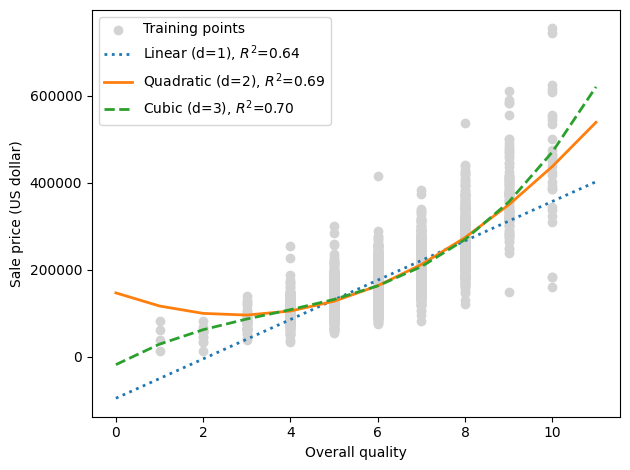

In [ ]:
# try `Overall Qual` feature
X = df[['Overall Qual']].values
y = df['SalePrice'].values

reg = LinearRegression()
quad = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quad.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min() - 1,
                  X.max() + 2,
                  1)[:, np.newaxis]

reg = reg.fit(X, y)
y_lin_pred = reg.predict(X_fit)
lin_r2 = r2_score(y, reg.predict(X))

reg = reg.fit(X_quad, y)
y_quad_pred = reg.predict(quad.fit_transform(X_fit))
quad_r2 = r2_score(y, reg.predict(X_quad))

reg = reg.fit(X_cubic, y)
y_cubic_pred = reg.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, reg.predict(X_cubic))

# plot result
plt.scatter(X, y,
            label='Training points',
            color='lightgray')

plt.plot(X_fit,
         y_lin_pred,
         label=f'Linear (d=1), $R^2$={lin_r2:.2f}',
         lw=2,
         linestyle=':')

plt.plot(X_fit,
         y_quad_pred,
         label=f'Quadratic (d=2), $R^2$={quad_r2:.2f}',
         lw=2,
         linestyle='-')

plt.plot(X_fit,
         y_cubic_pred,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         lw=2,
         linestyle='--')

plt.xlabel('Overall quality')
plt.ylabel('Sale price (US dollar)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Dealing with nonlinear relationships using random forests

### Decision tree regression

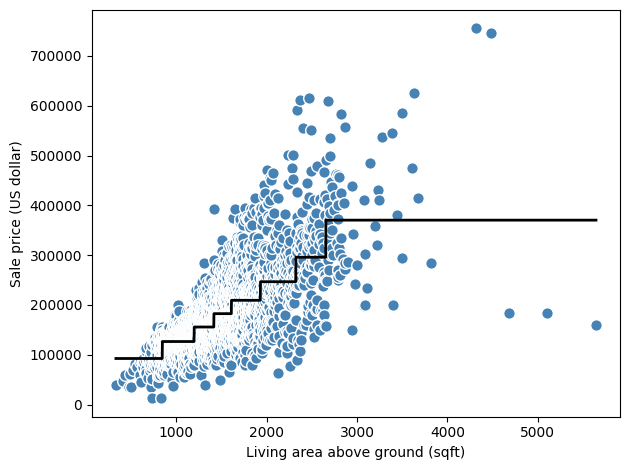

In [ ]:
# model relationship between SalePrice and Gr Liv Area variables
from sklearn.tree import DecisionTreeRegressor

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],
            y[sort_idx],
            tree)

plt.xlabel('Living area above ground (sqft)')
plt.ylabel('Sale price (US dollar)')
plt.tight_layout()
plt.show()

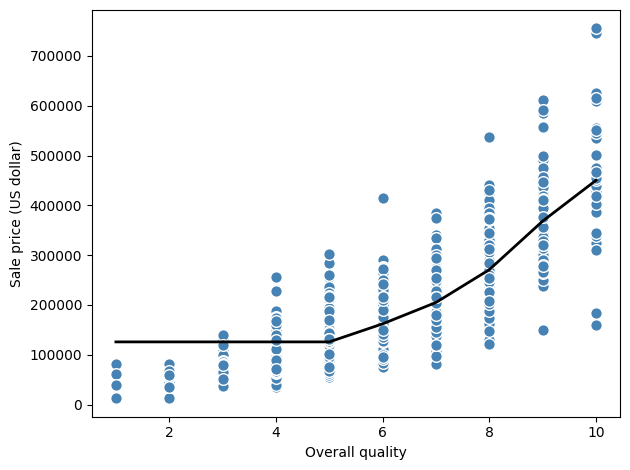

In [ ]:
# model Overall Qual and SalePrice
X = df[['Overall Qual']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],
            y[sort_idx],
            tree)

plt.xlabel('Overall quality')
plt.ylabel('Sale price (US dollar)')
plt.tight_layout()
plt.show()


### Random forest regression

In [ ]:
# use all features in Ames Housing dataset to fit a RFR model
# on 70 percent of examples and then evaluate its performance
from sklearn.model_selection import train_test_split

target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='squared_error',
                               n_jobs=-1)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

mae_train = mae(y_train, y_train_pred)
mae_test = mae(y_test, y_test_pred)

print(f'Train MAE: {mae_train:.2f}\n'
      f'Test MAE: {mae_test:.2f}')

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train R2: {r2_train:.2f}\n'
      f'Test R2: {r2_test:.2f}')

Train MAE: 8214.88
Test MAE: 22055.80
Train R2: 0.98
Test R2: 0.84


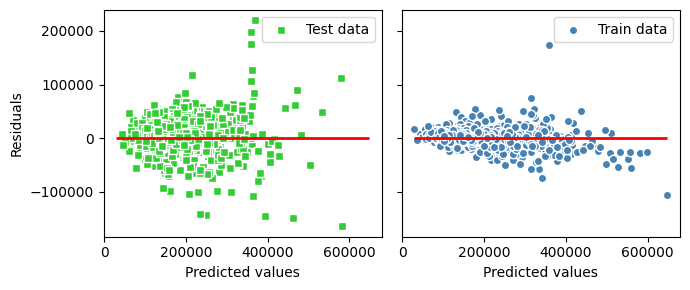

In [ ]:
# plot residuals
x_max = np.max(
    [np.max(y_train_pred), np.max(y_test_pred)]
)
x_min = np.min(
    [np.min(y_train_pred), np.min(y_test_pred)]
)

fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(7, 3),
                               sharey=True)

ax1.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            marker='s',
            edgecolor='white',
            label='Test data')

ax2.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            marker='o',
            edgecolor='white',
            label='Train data')

ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
  ax.set_xlabel('Predicted values')
  ax.legend(loc='best')
  ax.hlines(y=0,
            xmin=x_min - 100,
            xmax=x_max + 100,
            color='red',
            lw=2)

plt.tight_layout()
plt.show()